# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [195]:
! git clone https://github.com/ds4e/linearModels

fatal: destination path 'linearModels' already exists and is not an empty directory.


In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/linearModels/lab/data/airbnb_hw.csv')
print(df.columns)
df = df.rename(columns={'Neighbourhood ': 'Neighbourhood'})
print(df.columns)
df.head()

Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood ', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')
Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')


,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [197]:
print(df.dtypes)

Host Id                         int64
Host Since                     object
Name                           object
Neighbourhood                  object
Property Type                  object
Review Scores Rating (bin)    float64
Room Type                      object
Zipcode                       float64
Beds                          float64
Number of Records               int64
Number Of Reviews               int64
Price                          object
Review Scores Rating          float64
dtype: object


In [198]:
# Drop variables that will not be used
df = df.drop(['Host Id', 'Host Since', 'Name', 'Review Scores Rating (bin)', 'Zipcode', 'Number of Records', 'Number Of Reviews'], axis=1)

In [199]:
# Price is being read as an object, convert to numeric
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

In [200]:
df.head()

,Neighbourhood,Property Type,Room Type,Beds,Price,Review Scores Rating
0,Brooklyn,Apartment,Entire home/apt,1.0,145.0,NaN
1,Brooklyn,Apartment,Private room,1.0,37.0,NaN
2,Manhattan,Apartment,Private room,1.0,28.0,NaN
3,Manhattan,Apartment,Entire home/apt,3.0,199.0,NaN
4,Manhattan,Apartment,Private room,3.0,549.0,96.0


In [201]:
# Missing values
df.isna().sum()

,0
Neighbourhood,0
Property Type,3
Room Type,0
Beds,85
Price,181
Review Scores Rating,8323


In [202]:
# Drop all observations with missing values
df = df.dropna()
df.isna().sum()

,0
Neighbourhood,0
Property Type,0
Room Type,0
Beds,0
Price,0
Review Scores Rating,0


In [203]:
df['Neighbourhood'].unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'],
      dtype=object)

In [204]:
df['Property Type'].unique()

array(['Apartment', 'Other', 'Bed & Breakfast', 'Loft', 'House',
       'Condominium', 'Townhouse', 'Dorm', 'Boat', 'Cabin', 'Villa',
       'Bungalow', 'Camper/RV', 'Treehouse', 'Lighthouse', 'Chalet',
       'Castle', 'Hut'], dtype=object)

In [205]:
df['Room Type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [206]:
df.groupby('Neighbourhood')[['Price']].mean().reset_index()

,Neighbourhood,Price
0,Bronx,75.276498
1,Brooklyn,125.246925
2,Manhattan,178.484748
3,Queens,96.866499
4,Staten Island,95.351064


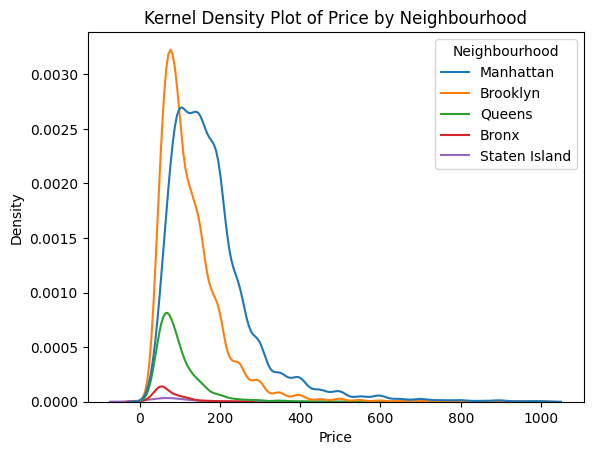

In [207]:
sns.kdeplot(data=df, x='Price', hue='Neighbourhood')
plt.title('Kernel Density Plot of Price by Neighbourhood')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

In [208]:
df.groupby('Property Type')[['Price']].mean().reset_index()

,Property Type,Price
0,Apartment,151.616405
1,Bed & Breakfast,103.095588
2,Boat,153.333333
3,Bungalow,143.666667
4,Cabin,165.000000
5,Camper/RV,66.666667
6,Castle,150.000000
7,Chalet,99.000000
8,Condominium,204.021277
9,Dorm,65.809524


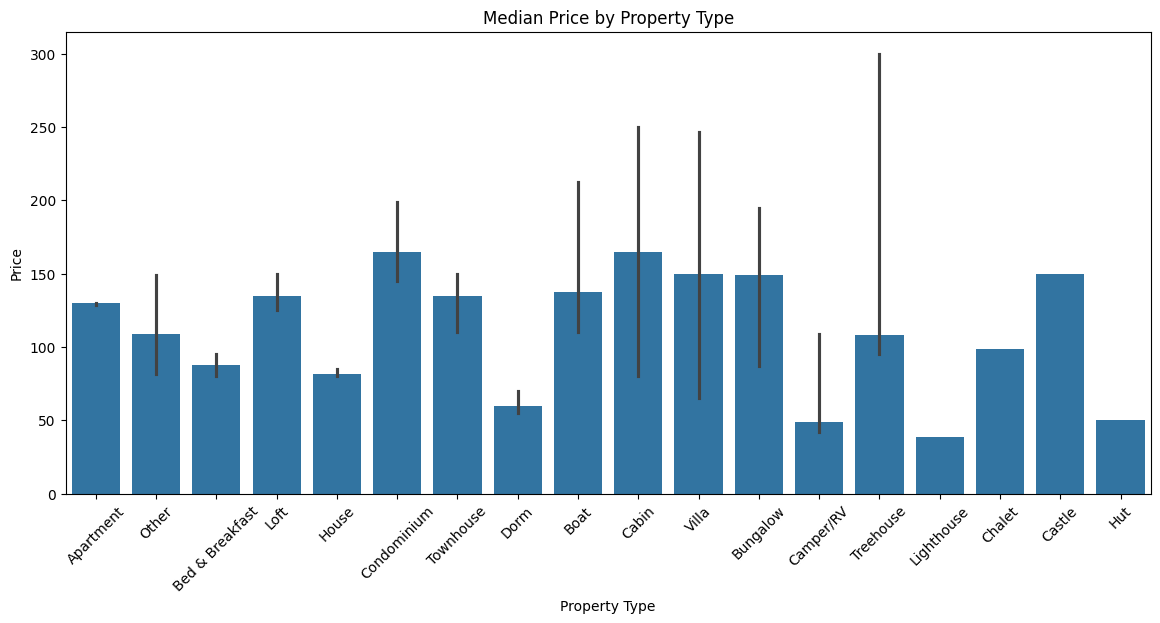

In [209]:
plt.figure(figsize=(14, 6))

sns.barplot(data=df, x='Property Type', y='Price', estimator=np.median)
plt.title('Median Price by Property Type')
plt.xticks(rotation=45)  # Rotate x labels if they overlap
plt.show()

In [210]:
df.groupby('Beds')[['Price']].mean().reset_index()

,Beds,Price
0,0.0,65.000000
1,1.0,122.510138
2,2.0,180.034063
3,3.0,225.220114
4,4.0,271.237458
5,5.0,323.274775
6,6.0,306.906475
7,7.0,320.894737
8,8.0,304.461538
9,9.0,565.000000


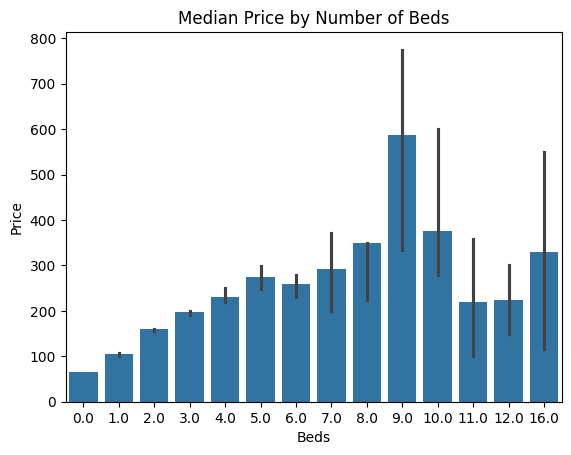

In [211]:
sns.barplot(data=df, x='Beds', y='Price', estimator=np.median)
plt.title('Median Price by Number of Beds')
plt.show()

In [212]:
df.groupby('Room Type')[['Price']].mean().reset_index()

,Room Type,Price
0,Entire home/apt,196.863164
1,Private room,88.250431
2,Shared room,67.865314


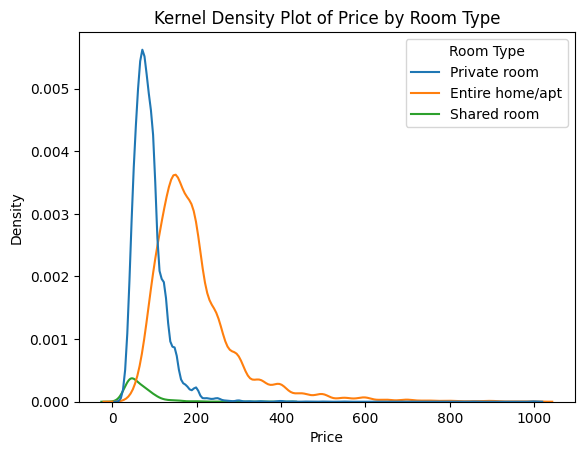

In [213]:
sns.kdeplot(data=df, x='Price', hue='Room Type')
plt.title('Kernel Density Plot of Price by Room Type')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

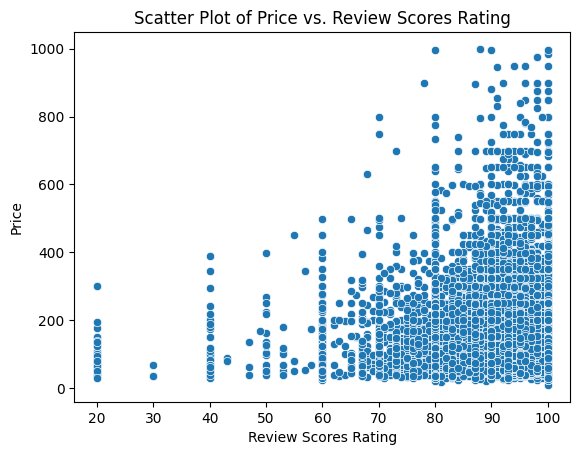

In [214]:
sns.scatterplot(data=df, x='Review Scores Rating', y='Price')
plt.title('Scatter Plot of Price vs. Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price')
plt.show()

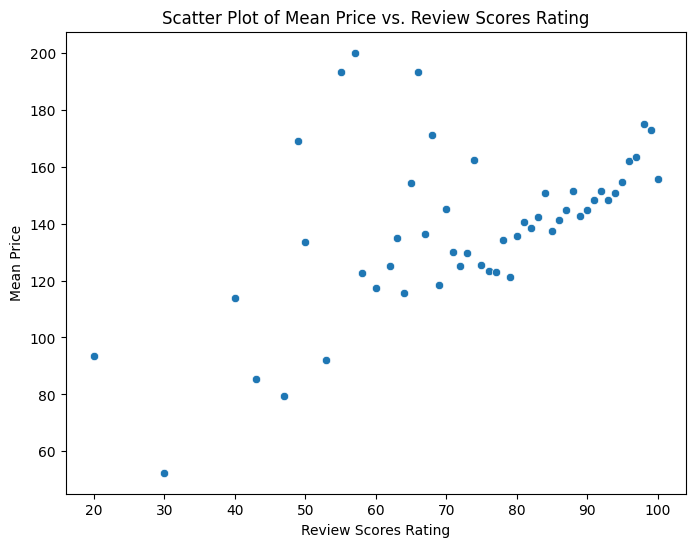

In [215]:
df_grouped = df.groupby('Review Scores Rating')[['Price']].mean().reset_index()

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_grouped, x='Review Scores Rating', y='Price')
plt.title('Scatter Plot of Mean Price vs. Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Mean Price')
plt.show()

In [216]:
df.columns

Index(['Neighbourhood', 'Property Type', 'Room Type', 'Beds', 'Price',
       'Review Scores Rating'],
      dtype='object')

In [217]:
# Transform categorical variables: room type, neighbourhood, property type, room type
df = pd.get_dummies(df, columns=['Neighbourhood', 'Property Type', 'Room Type'], dtype=int)

In [218]:
df.columns

Index(['Beds', 'Price', 'Review Scores Rating', 'Neighbourhood_Bronx',
       'Neighbourhood_Brooklyn', 'Neighbourhood_Manhattan',
       'Neighbourhood_Queens', 'Neighbourhood_Staten Island',
       'Property Type_Apartment', 'Property Type_Bed & Breakfast',
       'Property Type_Boat', 'Property Type_Bungalow', 'Property Type_Cabin',
       'Property Type_Camper/RV', 'Property Type_Castle',
       'Property Type_Chalet', 'Property Type_Condominium',
       'Property Type_Dorm', 'Property Type_House', 'Property Type_Hut',
       'Property Type_Lighthouse', 'Property Type_Loft', 'Property Type_Other',
       'Property Type_Townhouse', 'Property Type_Treehouse',
       'Property Type_Villa', 'Room Type_Entire home/apt',
       'Room Type_Private room', 'Room Type_Shared room'],
      dtype='object')

In [219]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.metrics import mean_squared_error

X = df.drop('Price', axis=1)
X.head()

y = df["Price"] # Target variable

# Split the sample:
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=65) # For replication purposes

Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?

In [220]:
# Single linear regression model, predicting price based off of Beds
print("Single linear regression model, predicting price based off of Beds")

X_train_beds = X_train[['Beds']]
X_test_beds = X_test[['Beds']]

reg_beds = LinearRegression().fit(X_train_beds, y_train)

print("R squared:",reg_beds.score(X_test_beds, y_test)) # R squared measure on test set

# Compute RMSE
y_test_pred = reg_beds.predict(X_test_beds)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)

Single linear regression model, predicting price based off of Beds
R squared: 0.1942933647327495
RMSE: 90.4868187718069


In [221]:
# Single linear regression model, predicting price based off of Review Scores Rating
print("Single linear regression model, predicting price based off of Review Scores Rating")

X_train_ratings = X_train[['Review Scores Rating']]
X_test_ratings = X_test[['Review Scores Rating']]

reg_ratings = LinearRegression().fit(X_train_ratings, y_train)

print("R squared:",reg_ratings.score(X_test_ratings, y_test)) # R squared measure on test set

# Compute RMSE
y_test_pred = reg_ratings.predict(X_test_ratings)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)

Single linear regression model, predicting price based off of Review Scores Rating
R squared: 0.00969159108306561
RMSE: 100.31874335860994


In [222]:
# Simple linear regression model, predicting price based off of Neighbourhood
print("Simple linear regression model, predicting price based off of Neighbourhood")

features = ['Neighbourhood_Bronx', 'Neighbourhood_Brooklyn', 'Neighbourhood_Manhattan', 'Neighbourhood_Queens', 'Neighbourhood_Staten Island']
X_train_neighbourhood = X_train[features]
X_test_neighbourhood = X_test[features]

reg_neighbourhood = LinearRegression().fit(X_train_neighbourhood, y_train)

print("R squared:",reg_neighbourhood.score(X_test_neighbourhood, y_test)) # R squared measure on test set
# Compute RMSE
y_test_pred = reg_neighbourhood.predict(X_test_neighbourhood)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)

Simple linear regression model, predicting price based off of Neighbourhood
R squared: 0.08624309634354788
RMSE: 96.36341568637158


In [223]:
# Simple linear regression model, predicting price based off of Property Type
print("Simple linear regression model, predicting price based off of Property Type")

features = ['Property Type_Apartment', 'Property Type_Bed & Breakfast', 'Property Type_Boat', 'Property Type_Bungalow', 'Property Type_Cabin', 'Property Type_Camper/RV', 'Property Type_Castle', 'Property Type_Chalet', 'Property Type_Condominium', 'Property Type_Dorm', 'Property Type_House', 'Property Type_Hut', 'Property Type_Lighthouse', 'Property Type_Loft', 'Property Type_Other', 'Property Type_Townhouse', 'Property Type_Treehouse', 'Property Type_Villa']
X_train_property = X_train[features]
X_test_property = X_test[features]

reg_property = LinearRegression().fit(X_train_property, y_train)

print("R squared:",reg_property.score(X_test_property, y_test)) # R squared measure on test set
# Compute RMSE
y_test_pred = reg_property.predict(X_test_property)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)

Simple linear regression model, predicting price based off of Property Type
R squared: 0.009815629387812441
RMSE: 100.31246059032652


In [224]:
# Simple linear regression model, predicting price based off of Room Type
print("Simple linear regression model, predicting price based off of Room Type ")

features = ['Room Type_Entire home/apt', 'Room Type_Private room', 'Room Type_Shared room']
X_train_room = X_train[features]
X_test_room = X_test[features]

reg_room = LinearRegression().fit(X_train_room, y_train)

print("R squared:",reg_room.score(X_test_room, y_test)) # R squared measure on test set
# Compute RMSE
y_test_pred = reg_room.predict(X_test_room)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)

Simple linear regression model, predicting price based off of Room Type 
R squared: 0.296884409685062
RMSE: 84.52987248396246


Based on the R squared and RMSE values, the model that predicts price based off of room type performs the best.

Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities?

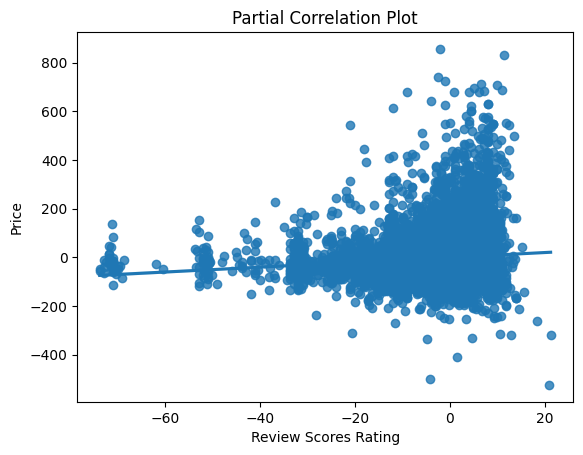

In [225]:
# Partial correlation plot for review scores rating and price
var =  'Review Scores Rating'
x_k = df[var]
X_mk = df.drop([var, "Price"],axis=1)
y = df['Price']

## 1. Regress y on x\k, save residual r_y
reg_y = LinearRegression(fit_intercept=False).fit(X_mk, y) # Fit the linear model
r_y = y - reg_y.predict(X_mk)

## 2. Regress x_k on x\k, save residual r_x
reg_k = LinearRegression(fit_intercept=False).fit(X_mk, x_k) # Fit the linear model
r_x = x_k - reg_k.predict(X_mk)

sns.regplot(y=r_y, x=r_x).set(title='Partial Correlation Plot')
plt.show()

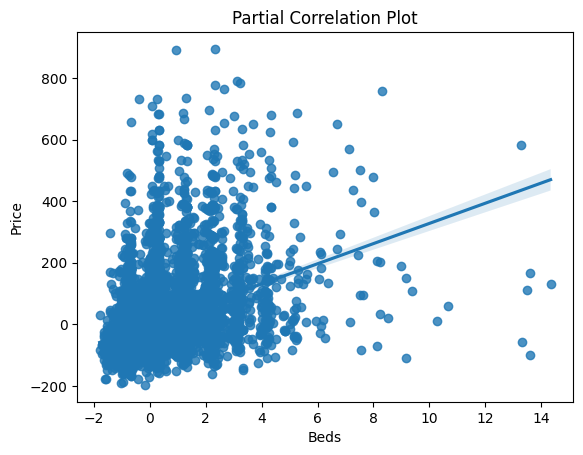

In [227]:
# Partial correlation plot for beds and price
var =  'Beds'
x_k = df[var]
X_mk = df.drop([var, "Price"],axis=1)
y = df['Price']

## 1. Regress y on x\k, save residual r_y
reg_y = LinearRegression(fit_intercept=False).fit(X_mk, y) # Fit the linear model
r_y = y - reg_y.predict(X_mk)

## 2. Regress x_k on x\k, save residual r_x
reg_k = LinearRegression(fit_intercept=False).fit(X_mk, x_k) # Fit the linear model
r_x = x_k - reg_k.predict(X_mk)

sns.regplot(y=r_y, x=r_x).set(title='Partial Correlation Plot')
plt.show()

It appears that that review scores rating have a non-linear effect on price.

Build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and  𝑅2  on the training and test sets. How does the more complex model you build compare to the simpler ones?

In [228]:
df.columns

Index(['Beds', 'Price', 'Review Scores Rating', 'Neighbourhood_Bronx',
       'Neighbourhood_Brooklyn', 'Neighbourhood_Manhattan',
       'Neighbourhood_Queens', 'Neighbourhood_Staten Island',
       'Property Type_Apartment', 'Property Type_Bed & Breakfast',
       'Property Type_Boat', 'Property Type_Bungalow', 'Property Type_Cabin',
       'Property Type_Camper/RV', 'Property Type_Castle',
       'Property Type_Chalet', 'Property Type_Condominium',
       'Property Type_Dorm', 'Property Type_House', 'Property Type_Hut',
       'Property Type_Lighthouse', 'Property Type_Loft', 'Property Type_Other',
       'Property Type_Townhouse', 'Property Type_Treehouse',
       'Property Type_Villa', 'Room Type_Entire home/apt',
       'Room Type_Private room', 'Room Type_Shared room'],
      dtype='object')

In [ ]:
# Account for non-linear relationship between review score ratings and price
df['Review Scores Rating Squared'] = df['Review Scores Rating'] ** 2

X = df.drop('Price', axis=1)
X.head()

y = df["Price"] # Target variable

# Split the sample:
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=65) # For replication purposes

In [ ]:
# Same model, but excluding property type and Neighbourhood features